# Neural ODE VAE
Implementazione di un Variational AutoEncoder per la ricostruzione, tramite Neural ODE di segnali EEG.

### Colab connection

In [1]:
!python --version
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 29.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully 

### Importing necessary Libraries

In [2]:
import argparse

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
matplotlib.use('agg')

import numpy as np
import numpy.random as npr
npr.seed(42)

import pandas as pd
import seaborn as sns

import logging
import logging.config
#logging.basicConfig(level=logging.INFO)  # Imposta il livello su INFO
# Reset logging se è già stato inizializzato
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Configurazione logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

logging.info("Ora il logging funziona!")

import torch
import torch.optim as optim
import torch.nn as nn

from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScale

import gc
import os
import glob
from torchdiffeq import odeint_adjoint as odeint

import time
from datetime import datetime as dt

import scipy
import scipy.signal as signal #per il calcolo della potenza
import scipy.stats as stats
from scipy.stats import ttest_rel
from scipy.stats import pearsonr
from scipy.signal import butter, filtfilt
#from scipy.integrate import RK45
from scipy.interpolate import interp1d

import mne
from mne.filter import filter_data
from torch.autograd.functional import jacobian

2025-05-17 10:13:55,390 - INFO - Ora il logging funziona!


### Data class
`data.py` It describes the class containing the data of the model

In [3]:
class Data:
    def __init__(self, orig_trajs, samp_trajs, orig_ts, samp_ts, labels=None, device=None):
        if device is None: #se il device non è stato assegnato allora usa la CPU
            device = 'cpu'
        try:
            orig_trajs = torch.from_numpy(orig_trajs).float()
            samp_trajs = torch.from_numpy(samp_trajs).float()
            samp_ts = torch.from_numpy(samp_ts).float()
            orig_ts = torch.from_numpy(orig_ts).float()

        except Exception:
            logging.warning('Inputs cannot be converted to torch (already a torch obj?)\n'
                            f'Types of orig_trajs, samp_trajs, orig_ts, samp_ts: {type(orig_trajs), type(samp_trajs), type(orig_ts), type(samp_ts)} ')

        self.samp_ts = samp_ts.to(device)
        self.samp_trajs = samp_trajs.to(device)
        self.orig_ts = orig_ts.to(device)
        self.orig_trajs = orig_trajs.to(device)
        self.labels = labels
        self.split(orig_trajs, samp_trajs, labels)#splitta i dati tra la parte di training e validation


    def get_samp_ts(self):#aggiunta ma da capire se serve o no
        return self.samp_ts

    @classmethod #possiamo chiamare questo metodo direttamente dalla classe, senza crearne un'istanza
    #NB: nei metodi di classe si usa cls per riferirsi alla classe stessa in modo generico
    def from_func(cls, func, device, **args):
        return cls(*func(**args), device=device)
        #Questo metodo chiama la funzione func (in questo caso load_data).load_data restituisce quattro tensori. Questi tensori vengono passati come argomenti alla classe Data, che li usa per creare un'istanza dell'oggetto Data.

    def split(self, orig_trajs, samp_trajs, labels, train_split=0.6, val_split=0.2):
        # We split the data across the spring dimension [nr. springs, nr. samples, values
        train_int = int(train_split * int(orig_trajs.shape[0]))
        val_int = int((train_split + val_split) * int(orig_trajs.shape[0]))

        # Divisione delle traiettorie campionate
        self.samp_trajs_train, self.samp_trajs_val, self.samp_trajs_test = (
          samp_trajs[:train_int, :, :],
          samp_trajs[train_int:val_int, :, :],
          samp_trajs[val_int:, :, :]
        )

    # Divisione dei tempi campionati


        #divisione delle traiettorie originali
        self.orig_trajs_train, self.orig_trajs_val, self.orig_trajs_test = (orig_trajs[:train_int, :, :],
                                                                            orig_trajs[train_int:val_int, :, :],
                                                                            orig_trajs[val_int:, :, :])
        #divisione delle traiettorie campionate
        self.samp_trajs_train, self.samp_trajs_val, self.samp_trajs_test = (samp_trajs[:train_int, :, :],
                                                                            samp_trajs[train_int:val_int, :, :],
                                                                            samp_trajs[val_int:, :, :])
        #divisione delle etichette, se presenti
        if labels:
            self.labels_train, self.labels_val, self.labels_test = (labels[:train_int],
                                                                    labels[train_int:val_int],
                                                                    labels[val_int:])

    def compute_validation_metrics(self, model):
    # Make sure the model is in evaluation mode
      model.eval()

      with torch.no_grad():
        # Use only the validation set for metric computation
        val_trajs = self.samp_trajs_val
        val_ts = self.samp_ts_val

        # Check if the tensors are on the correct device
        if val_trajs.device != model.device:
            val_trajs = val_trajs.to(model.device)
            val_ts = val_ts.to(model.device)

        # Compute model predictions
        val_preds = model(val_trajs, val_ts)

        # Calculate RMSE
        rmse_loss = self.RMSELoss(val_preds, val_trajs)

        # Calculate Pearson Correlation
        pearson_corr = self.compute_pearson_correlation(val_preds, val_trajs)

        # Log and print the results
        logging.info(f"Validation RMSE: {rmse_loss:.4f}, Pearson Correlation: {pearson_corr:.4f}")
        print(f"Validation RMSE: {rmse_loss:.4f}, Pearson Correlation: {pearson_corr:.4f}")

        return rmse_loss, pearson_corr



    def get_train_data(self):
        return self.samp_trajs_train, self.samp_ts

    def get_val_data(self):
        return self.samp_trajs_val, self.samp_ts

    def get_test_data(self):
        return self.samp_trajs_test, self.samp_ts, self.orig_trajs_test, self.orig_ts

    def get_all_data(self):
        return self.orig_trajs, self.samp_trajs, self.orig_ts, self.samp_ts

    def get_train_labels(self):
        return self.labels_train

    def get_val_labels(self):
        return self.labels_val

    def get_test_labels(self):
        return self.labels_test

    def get_all_labels(self):
        return self.labels

    @classmethod #metodo che non necessita di un'istanza della classe per essere chiamato
    def from_dict(cls, dict, device=None): #a partire da un dizionario dict crea un'istanza della classe
        labels = None
        if 'labels' in dict:
            labels = dict['labels']
            logging.info("Loading data labels")

        return cls(
            dict['orig_trajs'],
            dict['samp_trajs'],
            dict['orig_ts'],
            dict['samp_ts'],
            labels,
            device
        )

    def get_dict(self):
        return {
            'orig_trajs': self.orig_trajs,
            'samp_trajs': self.samp_trajs,
            'orig_ts': self.orig_ts,
            'samp_ts': self.samp_ts,
            'labels': self.labels,
        }

### Visualizer class
`visualize.py` definition of the class in order to visualize the plot

In [4]:
class Visualizer:
    def __init__(self,model, data: Data, save_folder: str):
        self.model = model
        self.data = data
        self.save_folder = save_folder + 'png/'
        self.device = model.device

    def visualize_step(self, version):
        now = dt.now().strftime('%H_%M')
        fname = f'v{version}_{now}.png'

        self.plot_reconstruction(fname)

    def visualize_final(self, version, t_pos=np.pi, t_neg=np.pi):
        now = dt.now().strftime('%H_%M')
        fname = f'{version}_{now}'
        self.plot_reconstruction(fname + '_reconstruction.png', t_pos=t_pos, t_neg=t_neg)
        self.plot_loss_history(fname + '_loss_history.png')

        #tolgo momentaneamnete questi due plot
        #self.plot_reconstruction_grid(fname + '_reconstruction_grid.png', t_pos=t_pos, t_neg=t_neg)
        #self.plot_original_grid(fname + '_original_grid.png')


    def latent_vis(self, fname, z_traj_idx=None, test=True, label=None, saved_data=None):
        # We make sure that we plot for the test sample trajectories if test = True
        if test:
            samp_trajs, samp_ts, orig_trajs, _ = self.data.get_test_data()
            #if label is None:
                #label = self.data.get_test_labels()
        else:
            orig_trajs, samp_trajs, _, samp_ts = self.data.get_all_data()
            if label is None:
                label = self.data.get_all_labels()

        with torch.no_grad():
            if isinstance(self.model, ODEAutoEncoder):
                # We forward pass to extract pred_x and z0 (we will only use z0)
                if saved_data is not None:
                    qz0_mean, qz0_logvar, epsilon = self.model.encode(saved_data)
                else:
                    qz0_mean, qz0_logvar, epsilon = self.model.encode(samp_trajs)

                # Sample z0 (vector) from q(z0)
                z0 = self.model.sample_z0(epsilon, qz0_logvar, qz0_mean)
                print("z0 size", z0.size())

                #from sklearn.manifold import TSNE

                #print("Applying t-SNE to latent vectors...")
                #tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42)
                #z0_red = tsne.fit_transform(z0.cpu().numpy())


                pca = PCA(n_components=2)
                pca.fit(z0)
                print("Explained variance:", pca.explained_variance_ratio_)
                z0_red = pca.fit_transform(z0)

                # print(z0_red.shape)
                print(z0_red[:, 0].shape)
                #print(len(label))

                # df=pd.DataFrame(z0_red,label)
                d = {'PC1': z0_red[:, 0], 'PC2': z0_red[:, 1], 'Label': label}
                df = pd.DataFrame(d)

                # print(len(df[df.Label==3].PC1))

                # z0 latent space plot
                if label is not None:
                  plt.figure()
    # z0 samples in 2D
                  colors = ["red", "green", "blue", "purple", "orange"]
                  condition_names = {
                    0: "baseline",
                    1: "vr1",
                    2: "vr2",
                    3: "vr3",
                    4: "vr4"
                  }
                  for i in np.unique(label):
                    plt.plot(
                      df[df.Label == i].PC1,
                      df[df.Label == i].PC2,
                      'o',
                      color=colors[i],
                      label=f'Condition: {condition_names.get(i, str(i))}',
                      linewidth=2,
                      zorder=1
                    )
                    plt.legend()
                else:
                  plt.figure()
                  plt.plot(
                    z0_red[:, 0],
                    z0_red[:, 1],
                    'o',
                    label='z0 samples in 2D',
                    linewidth=2,
                    zorder=1
                    )
                  plt.legend()

                logging.info('Saved reconstruction at {}'.format(self.save_folder + fname))
                plt.savefig(self.save_folder + 'z0' + fname, dpi=250)
                if z_traj_idx is not None:
                    ts_rmse = torch.from_numpy(np.linspace(0., torch.max(samp_ts), num=len(samp_ts))).to(self.device)
                    pred_x, pred_z = self.model.decode(z0, ts_rmse, return_z=True)

                    # print(pred_z.size())
                    # print(pred_z)

                    pca_z = PCA(n_components=2)
                    pca_z.fit(pred_z[z_traj_idx, :, :])
                    print(pca_z.explained_variance_ratio_)
                    pred_z_red = pca_z.fit_transform(pred_z[z_traj_idx, :, :])
                    print(pred_z_red.shape)

                    stype = label[z_traj_idx]
                    print(stype)
                    plt.figure()
                    plt.plot(pred_z_red[:, 0], pred_z_red[:, 1], 'o', color=colors[stype],
                             label=f'latent traj Spring type {stype}', linewidth=2,
                             zorder=1)
                    plt.legend()

                    logging.info('Saved reconstruction at {}'.format(self.save_folder + fname))
                    plt.savefig(self.save_folder + 'z_traj' + fname, dpi=250)

            elif isinstance(self.model, LSTMAutoEncoder):
                logging.info('Cannot sample latent space from Autoencoder baseline')


    def plot_reconstruction(self, fname, t_pos=np.pi, t_neg=np.pi, idx=0, test=False, toy=False):
        orig_trajs, samp_trajs, _, samp_ts = self.data.get_all_data()# We unwrap the trajectories from the data object
        #print("Valori asse x tempo: ",orig_trajs[idx, :, 0])

        # We make sure that we plot for the test sample trajectories if test = True
        if test: #la variabile test viene attivata per distinguere tra la modalità di addestramento o test
            samp_trajs, samp_ts, orig_trajs, _ = self.data.get_test_data()

        with torch.no_grad(): #PyTorch non memorizza i gradienti intermedi necessari per la backpropagation
            if isinstance(self.model, ODEAutoEncoder): #controlla se il modello è un ODEAutoEncoder

                qz0_mean, qz0_logvar, epsilon = self.model.encode(samp_trajs)# We forward pass to extract pred_x and z0 (we will only use z0)

                z0 = self.model.sample_z0(epsilon, qz0_logvar, qz0_mean)# Sample z0 (vector) from q(z0)

                # We generate new linspaces for extrapolation and negative extrapolation | We use the decode function to extract pred_x
                #ts_rmse = torch.from_numpy(np.linspace(1., torch.max(samp_ts).cpu().item(), num=len(samp_ts))).to(self.device)

                #ricostruzione
                ts_rec=samp_ts
                pred_x_rec=self.model.decode(z0,ts_rec)

            # Creiamo una finestra temporale per l'extrapolazione
                extrapolation_window = 10  # Numero di passi di extrapolazione
                num_extra_points = 3  # Quanti punti generare nell'extrapolazione

            # Creiamo la sequenza temporale per l'extrapolazione (pochi punti, non equidistanti)
                ts_max = torch.max(samp_ts).cpu().item()
                ts_extra = np.linspace(ts_max, ts_max + extrapolation_window, num=num_extra_points)
                ts_extra = torch.from_numpy(ts_extra).to(self.device)

            # Generiamo la traiettoria extrapolata con pochi punti
                pred_x_pos = self.model.decode(z0, ts_extra)

                #ts_pos = torch.from_numpy(np.linspace(0, torch.max(samp_ts).cpu().item() + t_pos, num=int(len(samp_ts)))).to(self.device)


                #pred_x_pos = self.model.decode(z0, ts_pos)
                #pred_x_rmse = self.model.decode(z0, ts_rmse)

                #val = int((t_pos / (torch.max(samp_ts) + t_pos)) * len(samp_ts)) #numero di punti di estrapolazione
                #pred_x_rec = pred_x_pos[:, :(len(samp_ts) - val), :]
                #pred_x_pos = pred_x_pos[:, (len(samp_ts) - val - 1):, :]
                #pred_x_rec=pred_x_pos[:,:]


                pred_x_pos = pred_x_pos.cpu().detach().numpy()
                pred_x_rec = pred_x_rec.cpu().detach().numpy()

                # We plot only the first trajectory
                orig_trajs = orig_trajs.cpu().detach()
                samp_trajs = samp_trajs.cpu().detach()

                if (t_neg > 0):
                    ts_neg = torch.from_numpy(np.linspace(-t_neg, 0., num=int(len(samp_ts) / 8))[::-1].copy()).to(
                        self.device)
                    pred_x_neg = torch.flip(self.model.decode(z0, ts_neg), dims=[1]).cpu().detach().numpy()

                    plt.figure()
                    plt.plot(orig_trajs[idx, :, 0].cpu().numpy(), orig_trajs[idx, :, 1].cpu().numpy(), 'g', label='True trajectory', linewidth=2,
                             zorder=1)

                    if isinstance(pred_x_rec, torch.Tensor):
                        pred_x_rec = pred_x_rec.cpu().numpy()

                    plt.plot(pred_x_rec[idx, :, 0], pred_x_rec[idx, :, 1], '-o', color='r', markersize=3,label='Reconstruction', zorder=3)

                    if isinstance(pred_x_pos, torch.Tensor):
                        pred_x_pos = pred_x_pos.cpu().numpy()

                    #plt.plot(pred_x_pos[idx, :, 0], pred_x_pos[idx, :, 1], '-o', color='c', markersize=3,
                    #label='Learned trajectory (t>0)', zorder=2)

                  # Se pred_x_neg è un tensore, converti in NumPy
                    if isinstance(pred_x_neg, torch.Tensor):
                        pred_x_neg = pred_x_neg.cpu().numpy()

                    #plt.plot(pred_x_neg[idx, :, 0], pred_x_neg[idx, :, 1], '-o', color='c', markersize=3,
                    #label='Learned trajectory (t<0)', zorder=2)
                    plt.scatter(samp_trajs[idx, :, 0].cpu().numpy(), samp_trajs[idx, :, 1].cpu().numpy(), color='b', label='Sampled data', s=10,
                                zorder=2)
                    plt.legend()
                else:
                    plt.figure()
                    plt.plot(orig_trajs[idx, :, 0].cpu().numpy(), orig_trajs[idx, :, 1].cpu().numpy(), 'g', label='True trajectory', zorder=1)
                    plt.plot(pred_x_rec[idx, :, 0], pred_x_rec[idx, :, 1], '-o', color = 'r', markersize = 3, label='Reconstruction', zorder=3)
                    #plt.plot(pred_x_pos[idx, :, 0].cpu().numpy(), pred_x_pos[idx, :, 1].cpu().numpy(), '-o', color='c', markersize=3,
                             #label='Learned trajectory (t>0)', zorder=3)
                    plt.scatter(samp_trajs[idx, :, 0].cpu().numpy(), samp_trajs[idx, :, 1].cpu().numpy(), color='b', label='Sampled data', s=3,
                                zorder=2)
                    plt.legend()

            elif isinstance(self.model, LSTMAutoEncoder):
                pred_x = self.model.forward(samp_trajs)

                plt.figure()
                plt.plot(orig_trajs[idx, orig_trajs[idx, :, 0] >= 0, 0].cpu().numpy(), orig_trajs[idx, orig_trajs[idx, :, 0] >= 0, 1].cpu().numpy(), 'g', label='true trajectory', zorder=1)
                plt.plot(pred_x[idx, :, 0].cpu().numpy(), pred_x[idx, :, 1].cpu().numpy(), 'r', label='learned trajectory (t>0)', zorder=3)
                plt.scatter(samp_trajs[idx, :, 0].cpu().numpy(), samp_trajs[idx, :, 1].cpu().numpy(), color='b', label='sampled data', s=3,
                            zorder=2)
                plt.legend()

        if not os.path.exists(self.save_folder):
          os.makedirs(self.save_folder)
        #logging.info('Saved reconstruction at {}'.format(self.save_folder + fname))
        plt.savefig(self.save_folder + fname, dpi=250)

        # Definisci la cartella per salvare le finestre ricostruite
        if combined_channels==3:
          save_dir = f"./Reconstructions/windowsize{window_size}/overlap{overlap}/SUB{subject}/condition{condition}/band{band}/channels_{channel}_{channel+1}_{channel+2}"
        if combined_channels==1:
          save_dir = f"./Reconstructions/windowsize{window_size}/overlap{overlap}/SUB{subject}/condition{condition}/band{band}/channel{channel}"
        if combined_channels==7:
          save_dir = f"/./Reconstructions/windowsize{window_size}/overlap{overlap}/SUB{subject}/condition{condition}/band{band}/channels_{channel}_{channel+1}_{channel+2}_{channel+3}_{channel+4}_{channel+5}_{channel+6}"

        os.makedirs(save_dir, exist_ok=True)

        if crossed==False: #per salvare solo la ricostruzione finale
          np.save(f"{save_dir}/final_reconstruction.npy", pred_x_rec if isinstance(pred_x_rec, np.ndarray) else pred_x_rec.cpu().detach().numpy())

        if crossed==True: #per salvare tutte le ricostruzioni
          npy_name = fname.replace("reconstruction", "final_reconstruction").replace(".png", ".npy")
          reconstruction = pred_x_rec[idx]  # shape: (window_size, 2)
          save_dir = os.path.join(
            "./Reconstructions",
            f"windowsize{window_size}",
            f"/overlap{overlap}"
            f"/SUB{subject}",
            f"/condition{condition}",
            f"/band{band}",
            f"/channel{channel}",
            f"/idx{idx}"
          )
          os.makedirs(save_dir, exist_ok=True)
          np.save(os.path.join(save_dir, npy_name), reconstruction)


        #np.save(f"./final_reconstruction_{band}_{channel}.npy",pred_x_rec if isinstance(pred_x_rec, np.ndarray) else pred_x_rec.cpu().detach().numpy())



    def plot_reconstruction_grid(self, fname, t_pos=np.pi, t_neg=np.pi, size=5, test=False):
        # We unwrap the trajectories from the data object
        orig_trajs, samp_trajs, _, samp_ts = self.data.get_all_data()

        # We make sure that we plot for the test sample trajectories if test = True
        if test:
            samp_trajs, samp_ts, orig_trajs, _ = self.data.get_test_data()

        with torch.no_grad():
            if isinstance(self.model, ODEAutoEncoder):
                # We forward pass to extract pred_x and z0 (we will only use z0)
                qz0_mean, qz0_logvar, epsilon = self.model.encode(samp_trajs)

                # Sample z0 (vector) from q(z0)
                z0 = self.model.sample_z0(epsilon, qz0_logvar, qz0_mean)

                # We generate new linspaces for extrapolation and negative extrapolation | We use the decode function to extract pred_x
            # Converte torch.max(samp_ts) in un numero scalare prima di passarlo a NumPy
                max_samp_ts = torch.max(samp_ts).cpu().item()

                ts_pos = torch.from_numpy(np.linspace(0., max_samp_ts + t_pos, num=len(samp_ts))).to(self.device)
                pred_x_pos = self.model.decode(z0, ts_pos).cpu().detach().numpy()

                if t_neg > 0:
                    ts_neg = torch.from_numpy(np.linspace(-t_neg, 0., num=int(len(samp_ts) / 8))[::-1].copy()).to(
                        self.device)
                    pred_x_neg = torch.flip(self.model.decode(z0, ts_neg), dims=[1]).cpu().detach().numpy()

                # Define extrapolation
                #val = int((t_pos / (torch.max(samp_ts) + t_pos)) * len(samp_ts))
                val=0
                pred_x_rec = pred_x_pos[:, :(len(samp_ts) - val), :]
                pred_x_pos = pred_x_pos[:, (len(samp_ts) - val - 1):, :]

                orig_trajs = orig_trajs.cpu().detach()
                samp_trajs = samp_trajs.cpu().detach()

                plt.figure(figsize=(15, 15))
                for i in range(size ** 2):
                    # We scale all y values to be 0:1
                    min_traj_y = np.min(orig_trajs.numpy()[i, :, 1])
                    max_traj_y = np.max(orig_trajs.numpy()[i, :, 1])
                    pred_x_rec_plt_y = (pred_x_rec[i, :, 1] - min_traj_y) / (max_traj_y - min_traj_y)
                    pred_x_pos_plt_y = (pred_x_pos[i, :, 1] - min_traj_y) / (max_traj_y - min_traj_y)
                    orig_trajs_plt_y = (orig_trajs[i, :, 1] - min_traj_y) / (max_traj_y - min_traj_y)

                    # We scale all x values to be 0:1
                    min_traj_x = np.min(orig_trajs.numpy()[i, :, 0])
                    max_traj_x = np.max(orig_trajs.numpy()[i, :, 0])
                    pred_x_rec_plt_x = (pred_x_rec[i, :, 0] - min_traj_x) / (max_traj_x - min_traj_x)
                    pred_x_pos_plt_x = (pred_x_pos[i, :, 0] - min_traj_x) / (max_traj_x - min_traj_x)
                    orig_trajs_plt_x = (orig_trajs[i, :, 0] - min_traj_x) / (max_traj_x - min_traj_x)

                    plt.subplot(size, size, i + 1)
                    plt.plot(pred_x_rec_plt_x, pred_x_rec_plt_y, '-o', color='r', markersize=1, label='Reconstruction',
                             zorder=3)
                    plt.plot(orig_trajs_plt_x, orig_trajs_plt_y, color='g', linewidth=1, label='True trajectory',
                             markersize=1, zorder=1)
                    #if t_pos > 0:
                        #plt.plot(pred_x_pos_plt_x, pred_x_pos_plt_y, '-o', color='c', markersize=3,
                                 #label='Learned trajectory (t>0)', zorder=2)
                    #if t_neg > 0:
                        #pred_x_neg_plt_y = (pred_x_neg[i, :, 1] - min_traj_y) / (max_traj_y - min_traj_y)
                        #pred_x_neg_plt_x = (pred_x_neg[i, :, 0] - min_traj_x) / (max_traj_x - min_traj_x)
                        #plt.plot(pred_x_neg_plt_x, pred_x_neg_plt_y, '-o', color='c', markersize=3,
                                 #label='Learned trajectory (t<0)', zorder=2)

                plt.legend(
                    #['Reconstruction', 'True trajectory', 'Learned trajectory (t>0)', 'Learned trajectory (t<0)'])
                    ['Reconstruction', 'True trajectory'])

            elif isinstance(self.model, LSTMAutoEncoder):
                pred_x = self.model.forward(samp_trajs)

                plt.figure(figsize=(15, 15))

                for i in range(size ** 2):
                    plt.subplot(size, size, i + 1)
                    plt.plot(orig_trajs[i, :, 0], orig_trajs[i, :, 1], 'g', label='true trajectory', zorder=1)
                    plt.plot(pred_x[i, :, 0], pred_x[i, :, 1], 'r', label='learned trajectory (t>0)', zorder=3)
                    plt.scatter(samp_trajs[i, :, 0], samp_trajs[i, :, 1], color='b', label='sampled data', s=3,
                                zorder=2)
                plt.legend()

            #logging.info('Saved reconstruction grid plot at {}'.format(self.save_folder + fname))
            plt.savefig(self.save_folder + fname, dpi=250)

    def plot_original_grid(self, fname):
        # We unwrap the trajectories from the data object
        orig_trajs, _, _, _ = self.data.get_all_data()

        orig_trajs = orig_trajs.cpu().detach()

        plt.figure(figsize=(15, 15))
        for i in range(25):
            plt.subplot(5, 5, i + 1)
            plt.scatter(x=orig_trajs[i, :, 0], y=orig_trajs[i, :, 1], color='b')

        plt.legend(['orig_trajs'])

        #logging.info('Saved original grid plot at {}'.format(self.save_folder + fname))
        plt.savefig(self.save_folder + fname, dpi=250)

    def plot_loss_history(self, fname):
        plt.figure(figsize=(15, 15))
        plt.plot(self.model.train_loss, color='b')
        plt.plot(self.model.val_loss, color='r')

        plt.legend(['train ELBO', 'validation ELBO'])

        #logging.info('Saved loss plot at {}'.format(self.save_folder + fname))
        plt.savefig(self.save_folder + fname, dpi=250)

    def plot_latent_space(self, fname):
        # We unwrap the trajectories from the data object
        orig_trajs, samp_trajs, orig_ts, samp_ts = self.data.get_all_data()

        # We forward pass to extract pred_x and z0
        pred_x, z0 = self.model.forward(samp_trajs, samp_ts, return_z0=True)

        # We use the decode function to extract pred_z
        pred_z = self.model.decode(z0, samp_ts, return_z=True)

        # Dunno if this is necessary
        pred_z = pred_z.cpu().detach().numpy()

        # We create the plot
        plt.figure(figsize=(15, 15))
        for i in range(9):
            plt.subplot(3, 3, i + 1)
            plt.scatter(x=pred_z[i, :, 0], y=pred_z[i, :, 1], color='r')
        plt.legend(['pred_z,'])
        plt.savefig(fname, dpi=250)
        plt.show()

    def plot_extrapolation(self):
        pass

    def RMSELoss(self, yhat, y):
        assert type(yhat) == torch.Tensor
        assert type(y) == torch.Tensor
        if y.device != yhat.device:
          y = y.to(yhat.device)

        return torch.sqrt(torch.mean((yhat - y) ** 2))

    def compute_means(self, yhat, y):
      #verifica che entrambi gli input siano tensori PyTorch
        assert isinstance(yhat, torch.Tensor)
        assert isinstance(y, torch.Tensor)

        mean_yhat = torch.mean(yhat)
        mean_y = torch.mean(y)

        return mean_yhat, mean_y

    def compute_var(self,yhat,y):
        assert isinstance(yhat,torch.Tensor)
        assert isinstance(y,torch.Tensor)

        var_yhat = torch.var(yhat, unbiased=False)  # Varianza di yhat
        var_y = torch.var(y, unbiased=False)  # Varianza di y

        return var_yhat, var_y

    def compute_pearson_correlation(self, yhat, y): #misura la correlazione lineare tra due tensori (valore tra -1 e 1)
    #controlla che entrambi gli input siano tensori PyTorch
        assert isinstance(yhat, torch.Tensor)
        assert isinstance(y, torch.Tensor)
        if y.device != yhat.device:
          y = y.to(yhat.device)

        #calcolo medie
        x_mean = torch.mean(yhat)
        y_mean = torch.mean(y)
        #print("La forma di yhat e y è: ", yhat.shape, y.shape)

        #centratura
        x_diff = yhat - x_mean
        y_diff = y - y_mean

        #calcolo del numeratore della formula di Pearson
        numerator = torch.sum(x_diff * y_diff)
        denominator = torch.sqrt(torch.sum(x_diff ** 2) * torch.sum(y_diff ** 2)) #radice quadrata del prodotto delle varianze

        correlation = numerator / (denominator + 1e-8)  # Per evitare divisioni per zero
        return correlation


    def computeRMSE_VAE(self, samp_trajs, samp_ts):
        with torch.no_grad():
            pred_x_rmse = self.model.forward(samp_trajs, samp_ts)
            rmse_loss = self.RMSELoss(pred_x_rmse, samp_trajs)

            return (rmse_loss.cpu().detach().numpy(), pred_x_rmse)

    def computeRMSE_AE(self, samp_trajs):
        with torch.no_grad():
            pred_x_rmse = self.model.forward(samp_trajs)
            rmse_loss = self.RMSELoss(pred_x_rmse, samp_trajs)

            return (rmse_loss.cpu().detach().numpy(), pred_x_rmse)


### Definition of the MODEL

In [5]:
###########################################
# UTILITY FUNCTIONS
###########################################

def log_normal_pdf(x, mean, logvar):
    const = torch.from_numpy(np.array([2. * np.pi])).float().to(x.device)
    const = torch.log(const)
    return -.5 * (const + logvar + (x - mean) ** 2. / torch.exp(logvar))

def normal_kl(mu1, lv1, mu2, lv2):
    v1 = torch.exp(lv1)
    v2 = torch.exp(lv2)
    lstd1 = lv1 / 2.
    lstd2 = lv2 / 2.

    kl = lstd2 - lstd1 + ((v1 + (mu1 - mu2) ** 2.) / (2. * v2)) - .5
    return kl


###########################################
# ABSTRACT TRAINER MODEL
###########################################

class TrainerModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.train_loss = []
        self.val_loss = []
        self.epoch_time = []

    def train_step(self, x, t):
        x = x.to(self.device)  # Assicura che x sia su GPU
        t = t.to(self.device)  # Assicura che t sia su GPU

        pred_x = self.forward(x)
        raise NotImplementedError()

    @classmethod
    def from_checkpoint(cls, path):
        raise NotImplementedError()

    def get_params(self):
        raise NotImplementedError()

    def get_args(self):
        raise NotImplementedError()

    def get_state_dicts(self):
        raise NotImplementedError()


###########################################
# ODE IMPLEMENTATION --> definisce l'ODE latente dz(t)/dt=f
###########################################

class LatentODEfunc(nn.Module):
    def __init__(self, latent_dim=4, nhidden=20): #implementato come una rete neurale (ELU+MLP)
        super(LatentODEfunc, self).__init__()
        self.elu = nn.ELU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, latent_dim)
        self.nfe = 0

    def forward(self, t, x):
        out = self.fc1(x)
        out = self.elu(out)
        out = self.fc2(out)
        out = self.elu(out)
        out = self.fc3(out)

        if out.requires_grad:
            self.nfe += 1

        return out


###########################################
# ENCODER IMPLEMENTATION--> RNN oppure LSTM, apprende la distribuzione q(z0) dello stato latente
###########################################

class RecognitionRNN(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=2, nhidden=25):
        super(RecognitionRNN, self).__init__()
        #logging.info('Setting up RNN')
        self.nhidden = nhidden
        self.i2h = nn.Linear(obs_dim + nhidden, nhidden)
        self.h2o = nn.Linear(nhidden, latent_dim * 2)

    def forward(self, x, h):
        combined = torch.cat((x, h), dim=1)
        h = torch.tanh(self.i2h(combined))
        out = self.h2o(h)
        return out, h

    def forward_sequence(self, x, device):
        h = self.init_hidden(batch=x.shape[0]).to(device)

        # Forward pass over all inputs for each time step
        # in reverse so we get z0 instead of z_T
        for t in reversed(range(x.size(1))):
            obs = x[:, t, :]
            out, h = self.forward(obs, h)

        return out

    def init_hidden(self, batch):
        return torch.zeros(batch, self.nhidden)


class LSTMEncoder(nn.Module):
    def __init__(self, input_size, nhidden, latent_dim):
        super(LSTMEncoder, self).__init__()
        self.nhidden = nhidden
        self.lstm = nn.LSTMCell(input_size, nhidden) #ho inserito 1 al posto di input_size
        self.h2o = nn.Linear(nhidden, latent_dim * 2)

    def forward(self, x, h, c):
        hn, cn = self.lstm(x, (h, c))
        out = self.h2o(hn)
        return out, hn, cn

    def forward_sequence(self, x, device):
        x = x.to(device)  #Sposta x su GPU

        h, c = self.init_hidden(batch=x.shape[0])
        h = h.to(device)  #Sposta hidden state su GPU
        c = c.to(device)
        hn = h.to(device)
        cn = c.to(device)
        cn = cn[0, :, :]
        hn = hn[0, :, :]
        # Forward pass over all inputs for each time step
        # in reverse so we get z0 instead of z_T
        for t in reversed(range(x.size(1))):
            obs = x[:, t, :].to(device)
            out, hn, cn = self.forward(obs, hn, cn)

        return out

    def init_hidden(self, batch):
        h = torch.zeros(1, batch, self.nhidden)
        c = torch.zeros(1, batch, self.nhidden)
        return [h, c]


class LSTMBaseline(nn.Module):
    def __init__(self, input_size, nhidden, latent_dim):
        super(LSTMBaseline, self).__init__()
        self.nhidden = nhidden
        self.latent_dim = latent_dim
        self.lstm = nn.LSTMCell(input_size, nhidden)
        self.lstm2 = nn.LSTMCell(nhidden, latent_dim)
        # self.activation = nn.ReLU(inplace=True)

    def forward(self, x, h1, c1, h2, c2):
        # Map inputs to hidden state from x -> h1
        # Map hidden state to latent dimension h1 -> h2
        x = x.to(self.device)  # Sposta x su GPU
        h1 = h1.to(self.device)  # Sposta h1 su GPU
        c1 = c1.to(self.device)  # Sposta c1 su GPU
        h2 = h2.to(self.device)  #Sposta h2 su GPU
        c2 = c2.to(self.device)

        hn1, cn1 = self.lstm(x, (h1, c1))
        hn2, cn2 = self.lstm2(hn1, (h2, c2))
        return hn1, cn1, hn2, cn2

    def forward_sequence(self, x, device):
        h1, c1, h2, c2 = self.init_hidden(batch=x.shape[0])
        h1 = h1.to(device)
        c1 = c1.to(device)

        output = []
        # Forward pass over all inputs for each time step
        for t in range(x.size(1)):
            obs = x[:, t, :]
            h1, c1, h2, c2 = self.forward(obs, h1, c1, h2, c2)
            output.append(h2)

        output = torch.stack(output, dim=1)
        return output

    def init_hidden(self, batch):
        h = torch.zeros(1, batch, self.nhidden)
        c = torch.zeros(1, batch, self.nhidden)
        c1 = c[0, :, :]
        h1 = h[0, :, :]

        h = torch.zeros(1, batch, self.latent_dim)
        c = torch.zeros(1, batch, self.latent_dim)
        c2 = c[0, :, :]
        h2 = h[0, :, :]
        return h1, c1, h2, c2


###########################################
# DECODER IMPLEMENTATION--> ricostruisce le traiettorie a partire dallo stato latente
###########################################

class Decoder(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=2, nhidden=20):
        super(Decoder, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, obs_dim)

    def forward(self, z):
        out = self.relu(self.fc1(z))
        out = self.fc2(out)
        return out


###########################################
# AUTOENCODER IMPLEMENTATION
###########################################

class LSTMAutoEncoder(TrainerModel):
    def __init__(self, latent_dim, obs_dim, hidden_dim, device=None):
        super(TrainerModel, self).__init__()
        if not device:
            self.device = 'cpu'
        else:
            self.device = device

        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.obs_dim = obs_dim

        # Model
        self.encoder = LSTMBaseline(input_size=obs_dim,
                                    nhidden=hidden_dim,
                                    latent_dim=latent_dim)

        self.decoder = LSTMBaseline(input_size=latent_dim,
                                    nhidden=hidden_dim,
                                    latent_dim=latent_dim)

        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, obs_dim, bias=False)
        self.relu = nn.ReLU(inplace=True)

        # Loss
        self.criterion = nn.MSELoss()

    def forward(self, x):
        z = self.encode(x)
        pred_x = self.decode(z)
        return pred_x

    def decode(self, z):
        x = self.decoder.forward_sequence(z, self.device)
        x = self.relu(self.fc1(x))
        out = self.fc2(x)
        return out

    def encode(self, x):
        z = self.encoder.forward_sequence(x, self.device)
        return z

    def train_step(self, x, t):
        pred_x = self.forward(x)

        # RMSE loss
        loss = torch.sqrt(self.criterion(x, pred_x))
        return loss

    @classmethod
    def from_checkpoint(cls, path):
        # Usage: LSTMAutoEncoder.from_checkpoint(path)
        obj = torch.load(path)
        model = cls(**obj['model_args'])
        model.encoder.load_state_dict(obj['encoder_state_dict'])
        model.decoder.load_state_dict(obj['decoder_state_dict'])
        model.fc1.load_state_dict(obj['fc1'])
        model.fc2.load_state_dict(obj['fc2'])

        model.train_loss = obj['train_loss']
        model.val_loss = obj['val_loss']

        return model

    def get_params(self):
        return list(self.encoder.parameters()) + list(self.decoder.parameters()) + \
               list(self.fc1.parameters()) + \
               list(self.fc2.parameters())

    def get_args(self):
        return {'latent_dim': self.latent_dim,
                'obs_dim': self.obs_dim,
                'hidden_dim': self.hidden_dim,
                'device': self.device}

    def get_state_dicts(self):
        return {
            'encoder_state_dict': self.encoder.state_dict(),
            'decoder_state_dict': self.decoder.state_dict(),
            'fc1': self.fc1.state_dict(),
            'fc2': self.fc2.state_dict(),
        }


class ODEAutoEncoder(TrainerModel):
    def __init__(self, data,latent_dim, obs_dim, hidden_dim, rnn_hidden_dim=None, lstm_hidden_dim=None, device=None,
                 solver='rk4'):
        super().__init__()
        #super(TrainerModel, self).__init__()

        self.latent_dim = latent_dim
        self.obs_dim = obs_dim
        self.rnn_hidden_dim = rnn_hidden_dim
        self.lstm_hidden_dim = lstm_hidden_dim
        self.hidden_dim = hidden_dim
        self.solver = solver
        self.data=data

        if device is None:
            self.device = 'cpu'
        else:
            self.device = device

#estrae z0
        if rnn_hidden_dim and not lstm_hidden_dim:
            self.encoder = RecognitionRNN(latent_dim, obs_dim, rnn_hidden_dim).to(device)
        elif lstm_hidden_dim and not rnn_hidden_dim:
            self.encoder = LSTMEncoder(obs_dim, lstm_hidden_dim, latent_dim).to(device)
        else:
            raise ValueError('Please satisfy rnn_hidden_dim xor lstm_hidden_dim')

        self.decoder = Decoder(latent_dim, obs_dim, hidden_dim).to(device)

#risolve dz/dt=f
        self.odefunc = LatentODEfunc(latent_dim, hidden_dim).to(device)
        self.nfe_list = []  # Length of nfe_list is number of epochs

    def check_stiffness(self, z0_sample=None, t0_sample=None):

      if z0_sample is None:
        # Usa un batch di dati dalla validation/test set
        samp_trajs, samp_ts, *_ = self.data.get_test_data()
        qz0_mean, qz0_logvar, epsilon = self.encode(samp_trajs)
        z0_sample = self.sample_z0(epsilon, qz0_logvar, qz0_mean)[0]
        t0_sample = samp_ts[0].item() if t0_sample is None else t0_sample

      z0_sample = z0_sample.detach().clone().requires_grad_(True)

      def f(z):
        return self.odefunc(t0_sample, z.unsqueeze(0)).squeeze(0)

      J = jacobian(f, z0_sample)
      eigvals = torch.linalg.eigvals(J)
      stiffness_ratio = torch.abs(eigvals).max() / (torch.abs(eigvals).min() + 1e-12)

      print(f" Stiffness ratio: {stiffness_ratio.item():.2e}")
      return stiffness_ratio.item()


    def forward(self, x, t, return_z0=False):
        # Encode
        qz0_mean, qz0_logvar, epsilon = self.encode(x)

        # Sample z0 (vector) from q(z0)
        z0 = self.sample_z0(epsilon, qz0_logvar, qz0_mean)

        # Decode
        pred_x = self.decode(z0, t)

        if return_z0:
            return pred_x, z0
        return pred_x

#epsilon: rumore gaussiano
    def sample_z0(self, epsilon, qz0_logvar, qz0_mean):
        z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean
        return z0

    def encode(self, x):
        out = self.encoder.forward_sequence(x, self.device)

        # Get the q(z0) distribution (as a vector)
        qz0_mean, qz0_logvar = out[:, :self.latent_dim], out[:, self.latent_dim:]
        epsilon = torch.randn(qz0_mean.size()).to(self.device)

        return qz0_mean, qz0_logvar, epsilon


    def decode(self, z0, t, return_z=False):
        # forward in time and solve ode for reconstructions
        pred_z = odeint(self.odefunc, z0, t, method=self.solver).permute(1, 0, 2) #usa odeint derivante dal torchdiffeq
        #pred_z=RK45(self.odefunc,t0, z0, t, max_step=inf, rtol=0.001, atol=1e-06, vectorized=False, first_step=None).permute(1,0,2)
        pred_x = self.decoder(pred_z)

        if return_z:
            return pred_x, pred_z

        return pred_x


    def train_step(self, x, t):
#x: samp_trajs_train oppure samp_trajs_val
#t: samp_ts

        # Encode
        qz0_mean, qz0_logvar, epsilon = self.encode(x)

        # Sample z0 (vector) from q(z0)
        z0 = self.sample_z0(epsilon, qz0_logvar, qz0_mean)
        #samp_ts=self.data.get_samp_ts()

        # Decode
        pred_x = self.decode(z0, t)  # potremmo forzare t ad essere pari a samp_ts


        noise_std_ = torch.zeros(pred_x.size()).to(self.device) + .2
        noise_logvar = 2. * torch.log(noise_std_).to(self.device)

        logpx = log_normal_pdf(x, pred_x, noise_logvar).sum(-1).sum(-1)

        #fixed_logvar = -5  # Fix log-variance to a very small value
        #noise_logvar = torch.full_like(pred_x, fixed_logvar).to(self.device)

        #logpx = log_normal_pdf(x, pred_x, noise_logvar).sum(-1).sum(-1)


        pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(self.device)

        analytic_kl = normal_kl(qz0_mean, qz0_logvar,
                                pz0_mean, pz0_logvar).sum(-1)

        elbo = torch.mean(-logpx + analytic_kl, dim=0)

        if elbo.requires_grad:
            self.save_nfe()


        return elbo

    def save_nfe(self):
        # save number of current forward passes
        self.nfe_list.append(self.odefunc.nfe)
        # Reset for next epoch
        self.odefunc.nfe = 0
        return

    @classmethod
    def from_checkpoint(cls, path):
        obj = torch.load(path)
        model = cls(**obj['model_args'])
        model.odefunc.load_state_dict(obj['odefunc_state_dict'])
        model.encoder.load_state_dict(obj['encoder_state_dict'])
        model.decoder.load_state_dict(obj['decoder_state_dict'])

        if 'nfe_list' in obj:
            model.nfe_list = obj['nfe_list']

        model.train_loss = obj['train_loss']
        model.val_loss = obj['val_loss']

        return model

    def get_params(self):
        return list(self.odefunc.parameters()) + list(self.decoder.parameters()) + list(self.encoder.parameters())

    def get_args(self):
        return {'latent_dim': self.latent_dim,
                'obs_dim': self.obs_dim,
                'hidden_dim': self.hidden_dim,
                'rnn_hidden_dim': self.rnn_hidden_dim,
                'lstm_hidden_dim': self.lstm_hidden_dim,
                'device': self.device,
                'solver': self.solver}

    def get_state_dicts(self):
        return {'odefunc_state_dict': self.odefunc.state_dict(),
                'encoder_state_dict': self.encoder.state_dict(),
                'decoder_state_dict': self.decoder.state_dict(),
                'nfe_list': self.nfe_list}

###Trainer class
`train.py` class to define the training of the entire algorithm

In [6]:
class Trainer:
    def __init__(self, model, optim, data, epochs, freq, folder=None, visualizer=None):
        assert isinstance(model, TrainerModel)
        self.model: TrainerModel = model
        self.optimizer = optim
        self.data = data
        self.epochs = epochs
        self.freq = freq

        if folder is None:
            self.folder = 'runs/model_' + dt.now().strftime("%m%d_%H%M")
        else:
            self.folder = folder

        if visualizer is None:
            self.visualizer = None
        else:
            self.visualizer = visualizer

        logging.info(f'Instantiated trainer object with model {model}\n'
                     f'and saving in folder {self.folder}\n'
                     f'over {epochs} epochs logging every {freq} epoch')

    @classmethod
    def from_checkpoint(cls, model_class, path, epochs, freq, folder):
        obj = torch.load(path)

        model = model_class.from_checkpoint(path)
        optimizer = optim.Adam(model.get_params(), lr=0)
        optimizer.load_state_dict(obj['optimizer_state_dict'])

        data = Data.from_dict(obj['data'])

        visualizer = Visualizer(model, data, folder)

        trainer = cls(model, optimizer, data, epochs, freq,
                      folder=folder, visualizer=visualizer)

        #logging.info(f"Loaded model from {path}")

        # Get the version from next index where v is 'runs/model_1204_1635/ckpt/16_35_v3.pth'
        version = 0
        return trainer, version

#viene chiamato nel main con trainer.train
    def train(self, version=0):
        logging.info('Inizia il training')

        try:
            for epoch in range(self.epochs):  #iterazioni per epoche
                start = time.time()

                self.train_step(*self.data.get_train_data()) #calcola ELBO e aggiorna i pesi
                #get_train_data restituisce: samp_trajs_train, samp_ts
                #print("get_train_data restituisce: ", *self.data.get_train_data())

                self.validation_step(*self.data.get_val_data()) # calcola errore sulla validazione

                end = time.time()
                self.model.epoch_time.append(end - start)

                if epoch % self.freq == 0: #ogni tot epoche
                    if isinstance(self.model, ODEAutoEncoder):
                        logging.info(f'Current number of forward passes: {self.model.nfe_list[-1]}')

                    logging.info('Epoch: {}, train elbo: {:.4f}, validation elbo: {:.4f}, mean time per epoch: {:.4f}'
                                 .format(epoch,
                                         self.model.train_loss[-1],
                                         self.model.val_loss[-1],
                                         np.mean(self.model.epoch_time)))
                    print("Salviamo il modello")
                    self.save_model(version)
                    print("Chiamiamo lo step di visualizzazione")
                    self.visualize_step(version)
                    version += 1

#logging e visualizzazione dei risultati alla fine di tutto il ciclo for
            logging.info(f'Training finished after {epoch} epochs')
            self.save_model('final')
            print("Visualizzazione finale")
            self.visualize_final()


        except KeyboardInterrupt:
            logging.info('Stopped training due to interruption')
            self.save_model(version)
            self.visualize_final('interrupted')

    def visualize_step(self, version):
        if self.visualizer:
            self.visualizer.visualize_step(version)

    def visualize_final(self, version='final'):
        if self.visualizer:
            self.visualizer.visualize_final(version)

#viene chiamata in train con input samp_trajs_train, samp_ts oppure samp_trajs_val, samp_ts
    def train_step(self, x, t):

        self.model.train() #attiva il modello in modalità training

        self.optimizer.zero_grad() #azzera i gradienti dell'ottimizzatore

        # Perform train step
        elbo = self.model.train_step(x, t)

        # Backwards pass and update optimizer and train loss
        elbo.backward() #calcola il gradiente della loss rispetto ai pesi del modello usando il backpropagation
        self.optimizer.step() #aggiorna i pesi del modello utilizzando l'ottimizzatore
        self.model.train_loss.append(-elbo.item()) #salva la loss nella lista train_loss del modello


    def validation_step(self, x, t):
      self.model.eval()

      with torch.no_grad():
        # Compute the ELBO for the current validation step
        elbo = self.model.train_step(x, t)
        self.model.val_loss.append(-elbo.item())

    def save_model(self, version):
        folder = os.path.join(self.folder, 'ckpt')

        now = dt.now().strftime('%H_%M')
        ckpt_path = os.path.join(folder, f'{now}_v{version}.pth')
#
        save_dict = {
            'model_args': self.model.get_args(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'data': self.data.get_dict(),
            'train_loss': self.model.train_loss,
            'val_loss': self.model.val_loss
        }
        save_dict.update(self.model.get_state_dicts())
        torch.save(save_dict, ckpt_path)

        logging.info(f"Saved model at {ckpt_path}")


In [7]:
def setup_folders(folder):
    if not os.path.exists(folder + 'png'): #controlla se la cartella folder+'png' esiste
        #logging.info(f"{folder + 'png'} does not exist... creating")
        os.makedirs(folder + 'png') #crea la directory nel percorso

    if not os.path.exists(folder + 'ckpt'):
        #logging.info(f"{folder + 'ckpt'} does not exist... creating")

        os.makedirs(folder + 'ckpt')

# Pre-processing

### Load of EEG dataset

In [8]:
def load_eeg_data(file_path, file_type='edf', mat_key='eeg_matrix', subject='unknown', condition='unknown'):
    """
    Carica EEG da file .edf o .mat e restituisce un dizionario con metadati nella chiave.

    Returns:
        dict con chiave formattata, sampling_rate, channel_names, times
    """
    if file_type == 'edf':
        raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
        eeg_data, times = raw.get_data(return_times=True)
        sampling_rate = raw.info['sfreq']
        channel_names = raw.ch_names

    elif file_type == 'mat':
        mat_data = scipy.io.loadmat(file_path)
        if mat_key not in mat_data:
            raise KeyError(f"'{mat_key}' not found in .mat file.")
        eeg_data = mat_data[mat_key]
        times = None
        sampling_rate = 250
        num_channels = eeg_data.shape[0]
        channel_names = [f"E{i+1}" for i in range(num_channels)]
    else:
        raise ValueError("file_type must be either 'edf' or 'mat'.")

    # Crea chiave identificativa
    key = f"{subject}_{condition}_{file_type}"

    # Ritorna tutto in un dizionario
    return {
        key: eeg_data,
        'sampling_rate': sampling_rate,
        'channel_names': channel_names,
        'times': times
    }


def load_and_plot_channel_locations(loc_file_path, show_labels=True, title="Scalp EEG Channel Locations"):
    """
    Carica e plotta le posizioni dei canali EEG da un file .loc (formato GSN_Hydrocel).

    Args:
        loc_file_path (str): path del file .loc
        show_labels (bool): se True mostra le etichette dei canali
        title (str): titolo del grafico

    Returns:
        loc_df: DataFrame con le coordinate e i label dei canali
    """
    loc_df = pd.read_csv(loc_file_path, sep='\s+', header=None)
    loc_df.columns = ['Index', 'Theta', 'Radius', 'Label']

    # Conversione da coordinate polari a cartesiane
    loc_df['Theta_rad'] = np.deg2rad(loc_df['Theta'])
    loc_df['X'] = loc_df['Radius'] * np.cos(loc_df['Theta_rad'])
    loc_df['Y'] = loc_df['Radius'] * np.sin(loc_df['Theta_rad'])

    %matplotlib inline

    # Plot
    plt.figure(figsize=(8, 8))
    plt.scatter(loc_df['X'], loc_df['Y'], s=80, c='skyblue', edgecolor='k')

    if show_labels:
        for _, row in loc_df.iterrows():
            plt.text(row['X'] + 0.005, row['Y'] + 0.005, row['Label'], fontsize=7)

    # Cerchio per simulare lo scalpo
    scalp = plt.Circle((0, 0), max(loc_df['Radius']), color='k', fill=False, linestyle='--')
    plt.gca().add_artist(scalp)

    plt.title(title)
    plt.axis('equal')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    return loc_df

###Importing .mat file

In [9]:
subject = '001'
condition = 'baseline'
file_type = 'mat'

result = load_eeg_data(
    file_path=f'./Dataset/SUB{subject}/SUB{subject}_eeg_{condition}.mat',
    file_type=file_type,
    subject=subject,
    condition=condition
)

# Accesso ai dati
key = f"{subject}_{condition}_{file_type}"
eeg_data = result[key]
sampling_rate = result['sampling_rate']
channel_names = result['channel_names']
times = result['times']

###Channels location

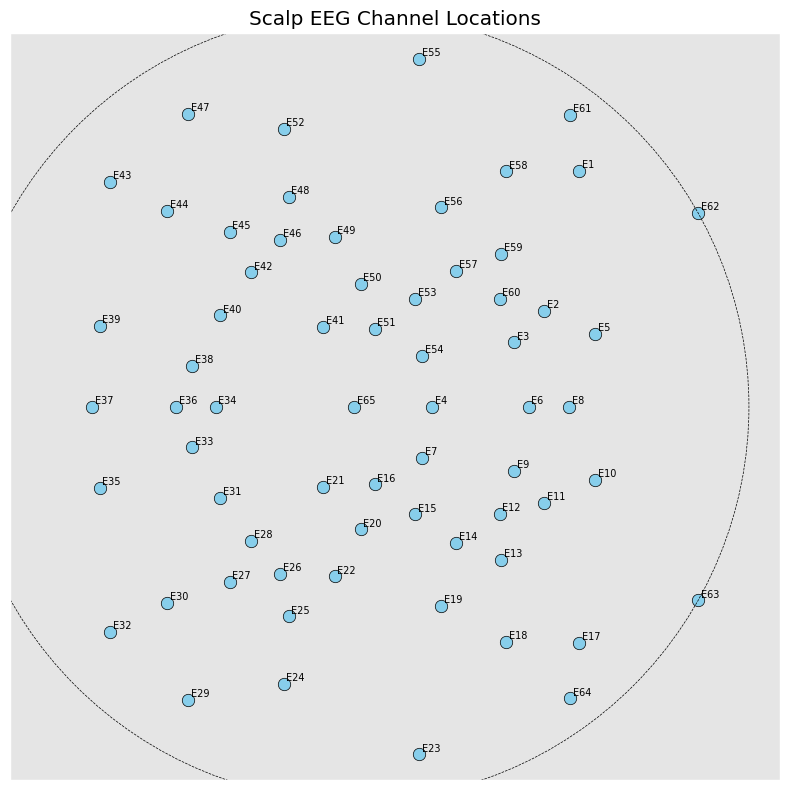

In [ ]:
loc_file = './GSN_Hydrocel_64.loc'
channel_locs_df = load_and_plot_channel_locations(loc_file, show_labels=True)

###FIR/IIR filtering

In [10]:
def fir_filter_eeg_data_vaeeeg(eeg_data, fs, bands=None,
                                fir_design='firwin', l_trans=0.1, h_trans=0.1, phase='zero'):
    """
    Applica filtraggio FIR stile VAEEG all'intero segnale EEG per ciascuna banda.

    Args:
        eeg_data (np.ndarray): EEG (n_channels x n_samples)
        fs (int): Frequenza di campionamento
        bands (dict): Dizionario bande {'Alpha': (8, 13), ...}
        fir_design (str): Tipo di FIR (default 'firwin')
        l_trans (float): Banda di transizione bassa (Hz)
        h_trans (float): Banda di transizione alta (Hz)
        phase (str): Tipo di fase ('zero' o 'minimum')

    Returns:
        dict: {banda: {ch_idx: segnale filtrato (shape = n_samples)}}
    """
    if bands is None:
        bands = {
            'Delta': (0.5, 4),
            'Theta': (4, 8),
            'Alpha': (8, 13),
            'Low_beta': (13, 20),
            'High_beta': (20, 30)
        }

    n_channels, n_samples = eeg_data.shape

    # Forza float64 per compatibilità MNE
    eeg_data = eeg_data.astype(np.float64)

    # Inizializza dizionario output
    filtered_data = {
        band: {} for band in bands
    }

    for ch_idx in range(n_channels):
        ch_signal = eeg_data[ch_idx]

        for band, (lowcut, highcut) in bands.items():
            try:
                filtered_signal = filter_data(
                    ch_signal,
                    sfreq=fs,
                    l_freq=lowcut,
                    h_freq=highcut,
                    method='fir',
                    fir_design=fir_design,
                    l_trans_bandwidth=l_trans,
                    h_trans_bandwidth=h_trans,
                    phase=phase,
                    verbose=False
                )
            except Exception as e:
                print(f"Errore filtrando canale {ch_idx}, banda {band}: {e}")
                filtered_signal = np.zeros_like(ch_signal)

            filtered_data[band][ch_idx] = filtered_signal

    return filtered_data

In [11]:
fs = 250
start_time = time.time()

filtered = fir_filter_eeg_data_vaeeeg(eeg_data, fs)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"FIR filtering took {elapsed_time:.4f} seconds.")

FIR filtering took 7.0130 seconds.


###Dataset splitting

In [13]:
def window_eeg_data(
    filtered_data,
    window_size,
    overlap,
    subject,
    condition,
    output_dir="/content/drive/MyDrive/Tesi/windows"
):
    """
    Suddivide i segnali EEG filtrati in finestre sovrapposte e salva ogni finestra per canale e banda.

    Args:
        filtered_data (dict): struttura {banda: {channel_number: segnale}}
        window_size (int): numero di campioni per finestra
        overlap (int): sovrapposizione tra finestre (in campioni)
        subject (str): identificativo soggetto
        condition (str): condizione (es. baseline, vr1...)
        output_dir (str): directory base dove salvare le finestre
    """
    step_size = window_size - overlap
    eeg_channel_indices = max([
        max(filtered_data[band].keys()) for band in filtered_data
    ])
    print(f"Numero di canali EEG validi: {eeg_channel_indices}")

    for ch_idx in range(eeg_channel_indices):
        channel_num = ch_idx + 1  # 1-based indexing

        for band in filtered_data.keys():
            if channel_num not in filtered_data[band]:
                print(f"Canale mancante: {channel_num} nella banda {band}. Salto...")
                continue

            signal = filtered_data[band][channel_num]
            n = len(signal)
            n_windows = (n - overlap) // step_size
            eeg_windows = np.zeros((n_windows, window_size, 2))

            for i in range(n_windows):
                start_idx = i * step_size
                end_idx = start_idx + window_size
                eeg_windows[i, :, 0] = np.arange(1, window_size + 1)
                eeg_windows[i, :, 1] = signal[start_idx:end_idx]

            # Salvataggio
            save_path = f"{output_dir}/windowsize{window_size}/overlap{overlap}/SUB{subject}/condition{condition}/eeg_{band}_channel_{channel_num}_windows.npy"
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            np.save(save_path, eeg_windows)
            print(f"Salvato: {save_path}")

    print(f"Total number of windows for each channel and each band: {n_windows}")

In [68]:
window_size=250
window_eeg_data(
    filtered_data=filtered,
    window_size=window_size,
    overlap=63,
    subject='001',
    condition='baseline',
    output_dir="./windows"
)

Numero di canali EEG validi: 64
Salvato: /content/drive/MyDrive/Tesi/windows/windowsize250/overlap63/SUB001/conditionbaseline/eeg_Delta_channel_1_windows.npy
Salvato: /content/drive/MyDrive/Tesi/windows/windowsize250/overlap63/SUB001/conditionbaseline/eeg_Theta_channel_1_windows.npy
Salvato: /content/drive/MyDrive/Tesi/windows/windowsize250/overlap63/SUB001/conditionbaseline/eeg_Alpha_channel_1_windows.npy
Salvato: /content/drive/MyDrive/Tesi/windows/windowsize250/overlap63/SUB001/conditionbaseline/eeg_Low_beta_channel_1_windows.npy
Salvato: /content/drive/MyDrive/Tesi/windows/windowsize250/overlap63/SUB001/conditionbaseline/eeg_High_beta_channel_1_windows.npy
Salvato: /content/drive/MyDrive/Tesi/windows/windowsize250/overlap63/SUB001/conditionbaseline/eeg_Delta_channel_2_windows.npy
Salvato: /content/drive/MyDrive/Tesi/windows/windowsize250/overlap63/SUB001/conditionbaseline/eeg_Theta_channel_2_windows.npy
Salvato: /content/drive/MyDrive/Tesi/windows/windowsize250/overlap63/SUB001/con

###Combined channels

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt

def window_eeg_concat_channels(
    filtered_data,
    window_size,
    overlap,
    subject,
    condition,
    channel_list,
    output_dir="./windows"
):
    """
    Crea finestre sovrapposte su ciascun canale EEG e concatena tutte le finestre
    in un unico array, salvato per ogni banda.

    Args:
        filtered_data (dict): {banda: {channel_number: segnale 1D}}
        window_size (int): lunghezza di ogni finestra (in campioni)
        overlap (int): sovrapposizione tra finestre (in campioni)
        subject (str): es. '001'
        condition (str): es. 'baseline'
        channel_list (list): lista dei canali da includere
        output_dir (str): directory base per il salvataggio
    """
    step_size = window_size - overlap
    total_windows_per_band = {}

    for band in filtered_data.keys():
        all_windows = []

        for ch in channel_list:
            if ch not in filtered_data[band]:
                print(f"Missing channel {ch} in band {band}, skipping...")
                continue

            signal = filtered_data[band][ch]
            T = len(signal)
            n_windows = (T - overlap) // step_size

            for i in range(n_windows):
                start_idx = i * step_size
                end_idx = start_idx + window_size
                if end_idx > T:
                    break

                window = np.zeros((window_size, 2))  # (time, signal)
                window[:, 0] = np.arange(1, window_size + 1)
                window[:, 1] = signal[start_idx:end_idx]
                all_windows.append(window)

        all_windows = np.stack(all_windows, axis=0)  # shape: (n_windows_total, window_size, 2)
        total_windows_per_band[band] = all_windows.shape[0]

        ch_str = "_".join(str(c) for c in channel_list)
        save_path = f"{output_dir}/windowsize{window_size}/SUB{subject}/condition{condition}/eeg_{band}_channels_{ch_str}_windows.npy"
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        np.save(save_path, all_windows)

        print(f"Salvato: {save_path} con shape {all_windows.shape}")

In [16]:
channel_list=[33, 34, 35]
combined_channels=len(channel_list)
window_eeg_concat_channels(
    filtered_data=filtered,
    window_size=40,
    overlap=20,
    subject='001',
    condition='baseline',
    channel_list=[33, 34, 35]
)

Salvato: /content/drive/MyDrive/Tesi/windows/windowsize40/SUB001/conditionbaseline/eeg_Delta_channels_33_34_35_windows.npy con shape (2208, 40, 2)
Salvato: /content/drive/MyDrive/Tesi/windows/windowsize40/SUB001/conditionbaseline/eeg_Theta_channels_33_34_35_windows.npy con shape (2208, 40, 2)
Salvato: /content/drive/MyDrive/Tesi/windows/windowsize40/SUB001/conditionbaseline/eeg_Alpha_channels_33_34_35_windows.npy con shape (2208, 40, 2)
Salvato: /content/drive/MyDrive/Tesi/windows/windowsize40/SUB001/conditionbaseline/eeg_Low_beta_channels_33_34_35_windows.npy con shape (2208, 40, 2)
Salvato: /content/drive/MyDrive/Tesi/windows/windowsize40/SUB001/conditionbaseline/eeg_High_beta_channels_33_34_35_windows.npy con shape (2208, 40, 2)


### Loading data

In [14]:
def load_data():
    if combined_channels==1:
      save_path = f"./windows/windowsize{window_size}/overlap{overlap}/SUB{subject}/condition{condition}/eeg_{band}_channel_{channel}_windows.npy"
    if combined_channels==3:
      save_path=f"./windows/windowsize{window_size}/SUB{subject}/condition{condition}/eeg_{band}_channels_{channel}_{channel+1}_{channel+2}_windows.npy"
    if combined_channels==7:
      save_path=f"/./windows/windowsize{window_size}/SUB{subject}/condition{condition}/eeg_{band}_channels_{channel}_{channel+1}_{channel+2}_{channel+3}_{channel+4}_{channel+5}_{channel+6}_windows.npy"

    data = np.load(save_path) #carica il file
    #data = np.load(f"./eeg_{band}_channel_{channel}_windows.npy")
    #print("Forma di eeg_windows: ",data.shape)
    n = data.shape[1] #window_size

    #creazione delle finestre temporali
    start = 1
    stop = window_size

    start_idx = int(n * 0.00)
    stop_idx = int(n * 1)

    #def dell'intervallo temporale
    orig_ts = np.linspace(start, stop, num=n) #generazione della sequenza temporale da 0 a window_size con n valori equidistanti
    #print("orig_ts: ",orig_ts)
    #orig_ts = (orig_ts - orig_ts.min()) / (orig_ts.max() - orig_ts.min())  # Normalizzazione 0-1

    #def dell'intervallo di campionamento
    samp_ts = orig_ts[start_idx:stop_idx] #selezione delle finestre temporali (dal 5% al 90% del dataset)
    #estrazione di una sotto-sequenza temporale
    #print("samp_ts: ",samp_ts)

    #normalizzazione delle traiettorie
    orig_trajs = [] #lista per memorizzare tutte le traiettorie normalizzate
    samp_trajs = [] #lista per memorizzare tutte le traiettorie dopo la selezione della finestra temporale
    #print("Numero totale di traiettorie: ", data.shape[0])
    for trajs in data: #per ogni finestra trajs presente in data
        #orig_traj = (trajs - trajs.mean()) / trajs.std() #normalizzazione--> media 0 e varianza 1
        #orig_traj = (trajs - trajs.min()) / (trajs.max() - trajs.min())
        orig_traj=trajs
        samp_traj = orig_traj[start_idx:stop_idx] #selezione solo la porzione di interesse

        #salvataggio nei rispettivi array
        orig_trajs.append(orig_traj)
        samp_trajs.append(samp_traj)

    orig_trajs = np.stack(orig_trajs, axis=0) #conversione in tensori PyTorch
    samp_trajs = np.stack(samp_trajs, axis=0)

    #in questo modo ci assicuriamo che i dati siano tutti nello stesso device, trasferimento su GPU se possibile
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    orig_trajs = torch.tensor(orig_trajs, dtype=torch.float32).to(device)
    samp_trajs = torch.tensor(samp_trajs, dtype=torch.float32).to(device)
    orig_ts = torch.tensor(orig_ts, dtype=torch.float32).to(device)
    samp_ts = torch.tensor(samp_ts, dtype=torch.float32).to(device)

    #print("shape orig_trajs:", orig_trajs.shape)
    #print("shape samp_trajs: ", samp_trajs.shape)
    #print("shape orig_ts:",  orig_ts.shape)
    #print("shape samp_ts:",samp_ts.shape)

    #plot_trajectories(orig_trajs, orig_ts, samp_trajs, samp_ts)

    return orig_trajs, samp_trajs, orig_ts, samp_ts

    #OUTPUT
    #orig_trajs: Traiettorie EEG normalizzate
    #samp_trajs:  Sottoinsieme delle traiettorie selezionate
    #orig_ts: Sequenza temporale completa.
    #samp_ts: Sottoinsieme della sequenza temporale

###Cleaning

In [15]:
def cleanup_after_band_channel(band, channel):
    """
    Pulisce memoria, GPU, figure e file temporanei per banda e canale specifici.


    Args:
        band (str): Nome della banda (es. 'Alpha', 'Gamma', ecc.)
        channel (int): Numero del canale (1-based)
        save_dir (str): Directory dove salvi metriche, ricostruzioni, ecc.
    """

    # Pulizia variabili intermedie (se esistono)
    for var_name in ['pred_x_rec', 'pred_x_pos', 'pred_x_neg',
                     'qz0_mean', 'qz0_logvar', 'epsilon', 'z0']:
        if var_name in globals():
            del globals()[var_name]

    # Garbage collection + GPU cache
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Pulizia matplotlib
    #plt.close('all')

    print(f"[✔] Pulizia completata per banda '{band}', canale {channel}")

### Main of the training
`main.py`\
To decide:


*   hyperparameters
*   which model to use



In [16]:
def reconstruct_from_windows(windows, window_size, overlap_steps, value_col=1):
    """
    Ricostruisce un segnale completo dalle finestre con passo fisso in campioni.

    Args:
        windows (np.ndarray): Array delle finestre (n_windows, window_size, n_features) o (n_windows, window_size)
        window_size (int): Dimensione della finestra in campioni
        overlap_steps (int): Numero di campioni di overlap tra finestre
        value_col (int): Colonna da considerare in caso di finestre multicanale

    Returns:
        np.ndarray: Segnale ricostruito
    """
    assert 0 <= overlap_steps < window_size, "Overlap must be in the range [0, window_size)"

    # Calcola lo step tra finestre
    step_size = window_size - overlap_steps
    total_length = step_size * (windows.shape[0] - 1) + window_size

    # Prealloca i vettori per il segnale ricostruito e i contatori
    signal = np.zeros(total_length)
    counts = np.zeros(total_length)

    # Ricostruzione del segnale
    for i, window in enumerate(windows):
        start = i * step_size
        end = start + window_size

        # Supporta finestre sia (window_size,) che (window_size, n_features)
        if window.ndim == 1:
            signal[start:end] += window
        else:
            signal[start:end] += window[:, value_col]

        counts[start:end] += 1

    # Evita divisione per zero
    counts[counts == 0] = 1
    return signal / counts

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def compute_val_metrics(base_path, window_size, overlap_steps, subject, condition, band, channel, combined_channels=1):
    """
    Calcola RMSE e Pearson correlation sul validation set (20% dopo il 60% del segnale) e salva il plot del validation set.

    Args:
        base_path (str): Directory principale.
        window_size (int): Dimensione della finestra in campioni.
        overlap_steps (int): Numero di campioni di overlap tra finestre.
        subject (str): ID del soggetto (es. "001").
        condition (str): Condizione (es. "baseline").
        band (str): Banda (es. "Alpha").
        channel (int): Numero del canale.
        combined_channels (int): Numero di canali combinati (1, 3 o 7).

    Returns:
        tuple: (RMSE, Pearson correlation)
    """
    # Percorsi ai file
    if combined_channels == 1:
        rec_path = f"{base_path}/Reconstructions/windowsize{window_size}/overlap{overlap_steps}/SUB{subject}/condition{condition}/band{band}/channel{channel}/final_reconstruction.npy"
        orig_path = f"{base_path}/windows/windowsize{window_size}/overlap{overlap_steps}/SUB{subject}/condition{condition}/eeg_{band}_channel_{channel}_windows.npy"
        plot_dir = f"{base_path}/Reconstructions/windowsize{window_size}/overlap{overlap_steps}/SUB{subject}/condition{condition}/band{band}/channel{channel}"
    elif combined_channels == 3:
        rec_path = f"{base_path}/Reconstructions/windowsize{window_size}/overlap{overlap_steps}/SUB{subject}/condition{condition}/band{band}/channels_{channel}_{channel+1}_{channel+2}/final_reconstruction.npy"
        orig_path = f"{base_path}/windows/windowsize{window_size}/SUB{subject}/condition{condition}/eeg_{band}_channels_{channel}_{channel+1}_{channel+2}_windows.npy"
        plot_dir = f"{base_path}/Reconstructions/windowsize{window_size}/overlap{overlap_steps}/SUB{subject}/condition{condition}/band{band}/channels_{channel}_{channel+1}_{channel+2}"
    elif combined_channels == 7:
        rec_path = f"{base_path}/Reconstructions/windowsize{window_size}/overlap{overlap_steps}/SUB{subject}/condition{condition}/band{band}/channels_{channel}_{channel+1}_{channel+2}_{channel+3}_{channel+4}_{channel+5}_{channel+6}/final_reconstruction.npy"
        orig_path = f"{base_path}/windows/windowsize{window_size}/SUB{subject}/condition{condition}/eeg_{band}_channels_{channel}_{channel+1}_{channel+2}_{channel+3}_{channel+4}_{channel+5}_{channel+6}_windows.npy"
        plot_dir = f"{base_path}/Reconstructions/windowsize{window_size}/overlap{overlap_steps}/SUB{subject}/condition{condition}/band{band}/channels_{channel}_{channel+1}_{channel+2}_{channel+3}_{channel+4}_{channel+5}_{channel+6}"
    else:
        raise ValueError("Invalid number of combined_channels. Use 1, 3, or 7.")

    # Creazione directory per salvare il plot
    os.makedirs(plot_dir, exist_ok=True)

    # Caricamento finestre
    windows_rec = np.load(rec_path)
    windows_orig = np.load(orig_path)

    # Ricostruzione segnali completi
    reconstructed_signal = reconstruct_from_windows(windows_rec, window_size, overlap_steps=overlap_steps, value_col=1)
    original_signal = reconstruct_from_windows(windows_orig, window_size, overlap_steps=overlap_steps, value_col=1)

    # Definizione degli indici per il validation set
    total_len = len(original_signal)
    val_start = int(total_len * 0.6)
    val_end = int(total_len * 0.8)

    # Estrazione del validation set
    original_val = original_signal[val_start:val_end]
    reconstructed_val = reconstructed_signal[val_start:val_end]

    # Calcolo RMSE
    rmse = np.sqrt(np.mean((original_val - reconstructed_val) ** 2))

    # Calcolo Pearson
    pearson_corr, _ = pearsonr(original_val, reconstructed_val)

    # Salvataggio del plot
    plot_path = os.path.join(plot_dir, "validation_plot.png")
    plt.figure(figsize=(15, 6))
    plt.plot(original_val, label="Original (Validation)", alpha=0.7)
    plt.plot(reconstructed_val, label="Reconstructed (Validation)", alpha=0.7)
    plt.title(f"Validation Set (Window Size: {window_size}, Overlap: {overlap_steps})\nRMSE: {rmse:.6f}, Pearson Corr: {pearson_corr:.6f}")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.savefig(plot_path)
    plt.close()

    print(f"RMSE: {rmse:.6f}, Pearson Correlation: {pearson_corr:.6f} for window_size: {window_size} and overlap: {overlap_steps}")
    print(f"Validation plot saved to: {plot_path}")

    return rmse, pearson_corr

In [ ]:
if __name__ == '__main__': #è un costrutto comune in Python usato per controllare se uno script è eseguito direttamente o importato come modulo in un altro script.
    parser = argparse.ArgumentParser()
    parser.add_argument('--dev', action='store_true')
    parser.add_argument('--epochs', type=int, default=10)
    parser.add_argument('--freq', type=int, default=50)
    parser.add_argument('--lr', type=float, default=1e-2)
    parser.add_argument('--load-dir', type=str, default='')
    parser.add_argument('--obs-dim', type=int, default=2)
    parser.add_argument('--latent-dim', type=int, default=4)
    parser.add_argument('--hidden-dim', type=int, default=20)
    parser.add_argument('--rnn-hidden-dim', type=int, default=None)
    parser.add_argument('--lstm-hidden-dim', type=int, default=None)
    parser.add_argument('--lstm-layers', type=int, default=1)
    parser.add_argument('--solver', type=str, default='rk4')
    parser.add_argument('--baseline', action='store_true')
    combined_channels=1
    #window_sizes = [10, 20, 30, 50, 100, 250]
    window_sizes=[10]
    overlap_percentages = [0, 0.25, 0.5]
    subject="001"
    condition="baseline"
    crossed=False

    args = parser.parse_args(args=[])  # Simula l'assenza di input da terminale

    # Imposta manualmente i valori desiderati
    # Dizionari con gli iperparametri per ogni banda
    epochs = {"Alpha": 400, "Low_beta": 600, "High_beta": 600, "Delta": 400, "Theta": 400}
    freq = {"Alpha": 100, "Low_beta": 100, "High_beta": 100, "Delta": 100, "Theta": 100}
    latent_dim = {"Alpha": 64, "Low_beta": 64, "High_beta": 64, "Delta": 64, "Theta": 64}
    hidden_dim = {"Alpha": 64, "Low_beta": 64, "High_beta": 64, "Delta": 64, "Theta": 64}
    lstm_hidden_dim = {"Alpha": 64, "Low_beta": 64, "High_beta": 64, "Delta": 64, "Theta": 64}
    lstm_layers = {"Alpha": 2, "Low_beta": 2, "High_beta": 2, "Delta": 2, "Theta": 2}
    solver = {"Alpha": 'rk4', "Low_beta": 'rk4', "High_beta": 'rk4', "Delta": 'rk4', "Theta": 'rk4'}
    lr= {"Alpha": 1e-3, "Low_beta": 1e-3, "High_beta": 1e-3, "Delta": 1e-3, "Theta": 1e-3}
    #bands = ["Alpha", "Beta", "Gamma", "Delta", "Theta"]
    bands = ["Alpha"]

    num_channels=33
    for window_size in window_sizes:
      overlaps = [int(np.ceil(w * window_size)) for w in overlap_percentages]
      for overlap in overlaps:
    # Loop su tutti i canali
        for channel in range(33,num_channels+1):  # Da 1 a num_channels+1
          print("Canale: ",channel)

          for band in bands:
            print("Sto processando la banda:", band)
            args.epochs = epochs[band]
            args.freq = freq[band]
            latent_dim = {"Alpha": 64, "Low_beta": 64, "High_beta": 64, "Delta": 64, "Theta": 64}
            epochs = {"Alpha": 400, "Low_beta": 600, "High_beta": 600, "Delta": 400, "Theta": 400}
        #print("latent_dim:", latent_dim, type(latent_dim))  # Debugging
            args.latent_dim = latent_dim[band]
            args.hidden_dim = hidden_dim[band]
            args.lstm_hidden_dim = lstm_hidden_dim[band]
            hidden_dim = {"Alpha": 64, "Low_beta": 64, "High_beta": 64, "Delta": 64, "Theta": 64}
            lstm_hidden_dim = {"Alpha": 64, "Low_beta": 64, "High_beta": 64, "Delta": 64, "Theta": 64}
            lstm_layers = {"Alpha": 2, "Low_beta": 2, "High_beta": 2, "Delta": 2, "Theta": 2}
            lr= {"Alpha": 1e-3, "Low_beta": 1e-3, "High_beta": 1e-3, "Delta": 1e-3, "Theta": 1e-3}
            solver = {"Alpha": 'rk4', "Low_beta": 'rk4', "High_beta": 'rk4', "Delta": 'rk4', "Theta": 'rk4'}
            args.lstm_layers = lstm_layers[band]
            args.lr = lr[band]
            args.solver = solver[band]

            tesi_folder = f"./{band}/{channel}"
            os.makedirs(tesi_folder, exist_ok=True)
        #cartella dove voglio salvare i runs
        #tesi_folder = f"./{band}/{channel}"
        #os.makedirs(tesi_folder, exist_ok=True)

            runs_folder = os.path.join(tesi_folder, "runs")

    # Creare la cartella 'runs' dentro 'Tesi' se non esiste
            os.makedirs(runs_folder, exist_ok=True)

            RUN_TIME = dt.now().strftime("%m%d_%H%M_%S") #genera una stringa con data e ora corrente per identificare in modo univoco una sessione di esecuzione
            MODEL_TYPE = 'eeg'
            root = runs_folder
            save_folder = os.path.join(root, f'{MODEL_TYPE}_model_{RUN_TIME}/')
            setup_folders(save_folder)

            log_file = f"{save_folder}logs_{RUN_TIME}.txt"
            logging.basicConfig(
              level=logging.DEBUG,
              format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
                handlers=[
                logging.FileHandler(log_file),
                logging.StreamHandler()
                ]
              )
            print(f"Logging salvato in: {log_file}")

            if args.dev:
              logging.info('Development run')
            else:
              logging.info('Production run')

        #logging.info(f'Starting {MODEL_TYPE} experiment')
        #logging.info(f'Passed arguments: {args}')

        # Model parameters
            latent_dim = args.latent_dim
            nhidden = args.hidden_dim
            rnn_nhidden = args.rnn_hidden_dim
            lstm_nhidden = args.lstm_hidden_dim
            lstm_layers = args.lstm_layers
            obs_dim = args.obs_dim

            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        #logging.info(f'On device {device}')

            data = Data.from_func(load_data,
                          device=device) #crea un'istanza della classe Data caricando i dati di input e trasferendoli su un dispositivo specifico


    #sceglie il modello in base al valore del parametro baseline che è una flag
            if not args.baseline:
              model = ODEAutoEncoder(data,latent_dim=latent_dim,
                               obs_dim=obs_dim,
                               rnn_hidden_dim=rnn_nhidden,
                               lstm_hidden_dim=lstm_nhidden,
                               hidden_dim=nhidden,
                               solver=args.solver,
                               device=device)
            else:
              model = LSTMBaseline(input_dim=obs_dim,
                             hidden_dim=lstm_nhidden,
                             layer_dim=lstm_layers,
                             device=device)

            stiffness_ratio = model.check_stiffness()
            if stiffness_ratio > 1e3:
              print("Il sistema è probabilmente stiff.")
            else:
              print("Il sistema non sembra stiff.")

    #ci assicuriamo che il modello sia sul device
            model.to(device)

            optimizer = optim.Adam(model.get_params(), lr=args.lr) #ottimizzazione di Adam: metodo per aggiornare i pesi minizzando la loss
        #logging.info(f"Optimizer: {optimizer}")

            visualizer = Visualizer(model, data, save_folder=save_folder) #crea un'istanza della classe Visualizer e la assegna alla variabile visualizer.

            if args.load_dir != '': #argomento passato da riga di comando che indica il percorso di un checkpoint salvato
              if not args.baseline:
                model_class = ODEAutoEncoder
              else:
                model_class = LSTMBaseline

              trainer, version = Trainer.from_checkpoint(model_class,
                                                   args.load_dir,
                                                   args.epochs,
                                                   args.freq,
                                                   save_folder) #carica un modello addestrato precedentemente e riprende l'allenamento da dove era stato interrotto
            else:
        #crea un'istanza della classe Trainer, che probabilmente si occupa di gestire l'addestramento del modello.
              trainer = Trainer(model=model,
                          optim=optimizer,
                          data=data,
                          visualizer=visualizer,
                          epochs=args.epochs,
                          freq=args.freq,
                          folder=save_folder)

              version = 0 #la variabile version serve a tenere traccia della versione del checkpoint quando si riprende l'allenamento da un modello salvato in precedenza

            start_time = time.time()
            trainer.train(version)  # avvio del training
# torch.save(model, "/content/drive/MyDrive/Tesi/trained_vae_full.pth")
            end_time = time.time()

            elapsed_time = end_time - start_time
            minutes = int(elapsed_time // 60)
            seconds = int(elapsed_time % 60)

            print(f"Training {band} channel {channel} took {minutes} min {seconds} sec")


#torch.save(model.state_dict(),'model_weights.pth')
        #logging.info("Saving final recontructions")
          if combined_channels==1:
            save_dir = f"./Reconstructions/windowsize{window_size}/overlap{overlap}/SUB{subject}/condition{condition}/band{band}/channel{channel}"
        #save_dir=f"/content/drive/MyDrive/Tesi/windows/windowsize{window_size}/SUB{subject}/condition{condition}/band{band}/channels_{channel}_{channel+1}_{channel+2}"

        #file_path = f"{save_dir}/final_reconstruction.npy"

        # Dopo il training
        #torch.save(model.state_dict(), f'/content/drive/MyDrive/Tesi/Reconstructions/windowsize{window_size}/overlap{overlap}/SUB{subject}/condition{condition}/band{band}/channel{channel}/model_weights.pth')
        #torch.save(model.state_dict(), f'/content/drive/MyDrive/Tesi/Reconstructions/windowsize{window_size}/overlap{overlap}/SUB{subject}/condition{condition}/eeg_{band}/channels_{channel}_{channel+1}_{channel+2}/model_weights.pth')

        # Carica la ricostruzione finale salvata dalla cartella Reconstructions locale
        #reconstructed_windows = np.load(f"{save_dir}final_reconstruction_{band}_{channel}.npy")

        #saving(save_dir)
            cleanup_after_band_channel(band, channel)
            base_path = "."

            rmse, pearson_corr = compute_val_metrics(base_path, window_size, overlap, subject, condition, band, channel, combined_channels)






2025-05-17 11:42:38,751 - INFO - Production run
2025-05-17 11:42:38,792 - WARNING - Inputs cannot be converted to torch (already a torch obj?)
Types of orig_trajs, samp_trajs, orig_ts, samp_ts: (<class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>) 


Canale:  33
Sto processando la banda: Alpha
Logging salvato in: /content/drive/MyDrive/Tesi/Alpha/33/runs/eeg_model_0517_1142_38/logs_0517_1142_38.txt


2025-05-17 11:42:38,925 - INFO - Instantiated trainer object with model ODEAutoEncoder(
  (encoder): LSTMEncoder(
    (lstm): LSTMCell(2, 64)
    (h2o): Linear(in_features=64, out_features=128, bias=True)
  )
  (decoder): Decoder(
    (relu): ReLU(inplace=True)
    (fc1): Linear(in_features=64, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=2, bias=True)
  )
  (odefunc): LatentODEfunc(
    (elu): ELU(alpha=1.0, inplace=True)
    (fc1): Linear(in_features=64, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=64, bias=True)
  )
)
and saving in folder /content/drive/MyDrive/Tesi/Alpha/33/runs/eeg_model_0517_1142_38/
over 400 epochs logging every 100 epoch
2025-05-17 11:42:38,927 - INFO - Inizia il training


 Stiffness ratio: 5.94e+03
Il sistema è probabilmente stiff.


2025-05-17 11:42:39,290 - INFO - Current number of forward passes: 1
2025-05-17 11:42:39,299 - INFO - Epoch: 0, train elbo: -5328.4849, validation elbo: -4970.5386, mean time per epoch: 0.3624
2025-05-17 11:42:39,351 - INFO - Saved model at /content/drive/MyDrive/Tesi/Alpha/33/runs/eeg_model_0517_1142_38/ckpt/11_42_v0.pth


Salviamo il modello
Chiamiamo lo step di visualizzazione


2025-05-17 11:42:55,534 - INFO - Current number of forward passes: 36
2025-05-17 11:42:55,535 - INFO - Epoch: 100, train elbo: -154.9734, validation elbo: -173.9663, mean time per epoch: 0.1539
2025-05-17 11:42:55,554 - INFO - Saved model at /content/drive/MyDrive/Tesi/Alpha/33/runs/eeg_model_0517_1142_38/ckpt/11_42_v1.pth


Salviamo il modello
Chiamiamo lo step di visualizzazione


2025-05-17 11:43:03,984 - INFO - Current number of forward passes: 36
2025-05-17 11:43:03,985 - INFO - Epoch: 200, train elbo: -50.4869, validation elbo: -51.9933, mean time per epoch: 0.1181
2025-05-17 11:43:04,004 - INFO - Saved model at /content/drive/MyDrive/Tesi/Alpha/33/runs/eeg_model_0517_1142_38/ckpt/11_43_v2.pth


Salviamo il modello
Chiamiamo lo step di visualizzazione
